# Data Download for Cardinale and Rose (2022b)
---

*[Cardinale and Rose (2022b)](https://www.essoar.org/doi/10.1002/essoar.10512237.1) is currently in preprint & review*
## Overview

1. [Find and import data from the CESM Large Ensemble (CESM_LE)](#1.-Find-and-import-data)
2. [Regrid data and convert from hybrid sigma-pressure to pressure levels](#2.-Regridding-and-interpolating)
3. [Calculate the Arctic averaged atmospheric energy flux convergence](#3.-Calculate-energy-transport,-moist-enthalpy-tendency,-and-polar-cap–averaged-surface-fluxes)
4. [Example figures using a subset of the data](#4.-Example-figures-and-the-surface-heating-efficiency)

**Approximate runtime:** 45 minutes

<div class="alert alert-info">
    
<strong>Note:</strong> CESM-LE data are available through the Amazon Web Services Simple Storage Service (AWS S3; <a href="https://ncar.github.io/cesm-lens-aws/">de La Beaujardière et al., 2019</a>). Calculations using CESM-LE data were performed using <a href="https://pangeo.io/cloud.html">Pangeo Cloud</a>, a cloud-based research platform (<a href="https://doi.org/10.1109/MCSE.2021.3059437">Abernathey et al., 2021</a>).
    
</div>

## 1. Find and import data
---

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scipy.integrate as integ
import dask
import gcsfs
from geocat.comp import interpolation
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import scipy.stats as sp
from scipy import signal
import intake
import xesmf as xe
%matplotlib inline
import json
import cartopy.crs as ccrs
import metpy
import seaborn as sns; sns.set(style="ticks", color_codes=True)

 CESM-LE data is loaded using the [**intake ESM**](https://intake-esm.readthedocs.io/en/latest/tutorials/index.html) package; some code is adapted from [Pangeo example notebooks](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html) that utilize CMIP6 data and from this [example notebook](http://gallery.pangeo.io/repos/NCAR/cesm-lens-aws/notebooks/kay-et-al-2015.v3.html) that reproduces results from [Kay et al. (2015)](https://doi.org/10.1175/BAMS-D-13-00255.1).

### Import user functions and functions adapted from `geocat.comp`

In [2]:
import comp.functions as comp
import comp.geocat_interp as gc
from comp.functions import C,A,ufunc2,sid,Cp,Lv,g,Rd

### Create Dask cluster

- To parallelize code, this notebook uses a [dask gateway](https://gateway.dask.org/) cluster with 8 cores and 24 GB of memory. 
- To avoid memory issues it appears best to reduce the amount of workers and increase the amount of threads per worker. 
    - Here, 1 [worker](https://distributed.dask.org/en/stable/worker.html#worker) process will be launched with 8 [threads](https://distributed.dask.org/en/stable/worker.html#thread-pool). 
- Dask is also useful for checking the progress of long tasks (*click on "Dashboard"*)

<div class="alert alert-info">
    
<strong>Note:</strong> To run without a dask cluster, skip the following cell.
    
</div>

In [3]:
from dask_gateway import Gateway
from dask.distributed import Client, progress

gateway = Gateway()
cluster = gateway.new_cluster(worker_cores=8,worker_memory=24)
cluster.adapt(minimum=1,maximum=1)
client = Client(cluster)
client.upload_file('comp/geocat_interp.py')
cluster

### Open catelog

In [4]:
cat_url = 'https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/catalogs/aws-cesm1-le.json'
cat = intake.open_esm_datastore(cat_url)
cat

,unique
variable,78
long_name,75
component,5
experiment,4
frequency,6
vertical_levels,3
spatial_domain,5
units,25
start_time,12
end_time,13


In [5]:
cat.df.variable.unique()

array(['FLNS', 'FLNSC', 'FLUT', 'FSNS', 'FSNSC', 'FSNTOA', 'ICEFRAC',
       'LHFLX', 'PRECL', 'PRECSC', 'PRECSL', 'PRECT', 'PRECTMX', 'PSL',
       'Q850', 'SHFLX', 'TMQ', 'TREFHT', 'TREFHTMN', 'TREFHTMX', 'TS',
       'UBOT', 'WSPDSRFAV', 'Z500', 'QBOT', 'VBOT', 'Q', 'T', 'U', 'V',
       'Z3', 'PS', 'QREFHT', 'PRECC', nan, 'aice_d', 'hi_d', 'aice', 'hi',
       'FSNO', 'H2OSNO', 'QRUNOFF', 'RAIN', 'SNOW', 'SOILWATER_10CM',
       'TREFMNAV_U', 'TREFMXAV_U', 'SOILLIQ', 'DIC', 'DOC', 'FW', 'HMXL',
       'O2', 'PD', 'QFLUX', 'QSW_HBL', 'QSW_HTP', 'RESID_S', 'SALT',
       'SFWF', 'SFWF_WRST', 'SHF', 'SHF_QSW', 'SSH', 'SST', 'TAUX',
       'TAUX2', 'TAUY', 'TAUY2', 'TEMP', 'UES', 'UET', 'UVEL', 'VNS',
       'VNT', 'VVEL', 'WTS', 'WTT', 'WVEL'], dtype=object)

In [6]:
#cat.df.long_name.unique() ####uncomment if abbreviations/acronyms are unfamiliar  

Calculations in this notebook require high frequency data (e.g., sub-daily), which is only available in 3 separate 10 to 16 year periods (1990–2005, 2026–2035, and 2071–2080) at a temporal resolution of 6-hours.

In [7]:
cat.df.frequency.unique()

array(['daily', 'hourly6-1990-2005', 'hourly6-2026-2035',
       'hourly6-2071-2080', 'monthly', 'static'], dtype=object)

In [8]:
cat.df.experiment.unique()

array(['20C', 'CTRL', 'HIST', 'RCP85'], dtype=object)

### Search catalog for subset of future RCP8.5 ensemble simulations

**Variables needed:**

- Specific Humidity (Q)
- Air Temperature (T)
- Geopotential Height (Z3) 
- Meridional Wind (V)
- Surface Pressure
- Downward Longwave Radiation (surface; FLNS)
- Latent Turbulent Heat Flux (surface; LHFLX)
- Sensible Turbulent Heat Flux (surface; SHFLX)
- Sea Ice Concentration (ICEFRAC)
- Temperature at 2-m (TREFHT)
- Clearsky Net Longwave Flux (surface; FLNSC)

[Cardinale and Rose (2022b)](https://www.essoar.org/doi/10.1002/essoar.10512237.1) uses both 20C (1990–2005; 16 years) and RCP8.5 (2071–2080; 10 years) runs. Here, only the RCP8.5 ensemble is downloaded—for the 20C ensemble, use `'hourly6-1990-2005'` for the `frequency` and `'20C'` for the `experiment` below.

In [9]:
cat_cesm_atm = cat.search(frequency='hourly6-2071-2080', variable = ['Q','T','Z3','V'])
cat_cesm_ps = cat.search(frequency='hourly6-2071-2080', variable = ['PS'])
cat_cesm_sfc = cat.search(frequency='daily',experiment='RCP85'
                           , variable = ['FLNSC','FLNS','SHFLX','LHFLX','ICEFRAC','TREFHT'])

<div class="alert alert-warning">
    
<strong>Warning:</strong> Check variables, some variables may not be stored despite showing up in the collection.
    
</div>

In [10]:
cat_cesm_sfc.df.variable

0       FLNS
1      FLNSC
2    ICEFRAC
3      LHFLX
4      SHFLX
5     TREFHT
Name: variable, dtype: object

### Open, chunk datasets, and select winter and Arctic region

In [11]:
time_6H = xr.cftime_range('2071-01-02','2080-12-31T18',freq='6H',calendar='noleap')
time_D =  xr.cftime_range('2071-01-02T12','2080-12-31T12',freq='D',calendar='noleap')
winter_6H_ext = time_6H.where(np.logical_or(time_6H.month>9,time_6H.month<5)).dropna()
winter_D_ext = time_D.where(np.logical_or(time_D.month>9,time_D.month<5)).dropna()

<div class="alert alert-info">

<strong>Note:</strong> <code>winter_ext</code> calendars also include October and April, some data from these months are needed for composite analysis
    
</div>

In [12]:
dict_cesm_atm = cat_cesm_atm.to_dataset_dict(aggregate=False, zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
dict_cesm_ps = cat_cesm_ps.to_dataset_dict(aggregate=False,zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
dict_cesm_sfc = cat_cesm_sfc.to_dataset_dict(aggregate=False,zarr_kwargs={"consolidated": True}, storage_options={"anon": True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.long_name.component.experiment.frequency.vertical_levels.spatial_domain.units.start_time.end_time.path'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.long_name.component.experiment.frequency.vertical_levels.spatial_domain.units.start_time.end_time.path'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.long_name.component.experiment.frequency.vertical_levels.spatial_domain.units.start_time.end_time.path'


In [ ]:
ds_cesm_atm = xr.merge([dict_cesm_atm[list(dict_cesm_atm.keys())[x]] 
                    for x in range(len(dict_cesm_atm.keys()))]).sel(lat=slice(69,90)).rename({'T':'TEMP'}).sel(time=slice('2071-01-02','2080-12-31T18')).sel(time=winter_6H_ext).chunk(chunks={'time': 420})

ds_cesm_ps = xr.merge([dict_cesm_ps[list(dict_cesm_ps.keys())[x]] 
                     for x in range(len(dict_cesm_ps.keys()))]).sel(lat=slice(69,90)).sel(time=slice('2071-01-02','2080-12-31T18')).sel(time=winter_6H_ext).chunk(chunks={'time': 420})

ds_cesm_sfc = xr.merge([dict_cesm_sfc[list(dict_cesm_sfc.keys())[x]] 
                     for x in range(len(dict_cesm_sfc.keys()))]).sel(lat=slice(-90,90)).shift(time=-1).sel(time=slice('2071-01-02','2080-12-31T18')).chunk(chunks={'time': 105})

### Load surface pressure if unavailable

Surface pressure data needed to convert the hybrid sigma-pressure levels to pressure levels are not available from 1990 to 2005. To address this issue, pressure data was downloaded from the [Climate Data Gateway at NCAR](https://www.cesm.ucar.edu/projects/community-projects/LENS/data-sets.html) and is stored on Google Cloud.

<div class="alert alert-info">

<strong>Note:</strong> This surface pressure data may be removed in the future; a solution would be to include the pressure data on AWS S3. Data requests can be made on <a href="https://github.com/NCAR/cesm-lens-aws/issues"> NCAR's CESM-LE GitHub repository</a>. For more information on CESM datasets, see the <a href="https://www.cesm.ucar.edu/projects/community-projects/">CESM projects</a> page.
    
</div>

In [ ]:
with open('instant-form-322214-fd342123ac85.json') as token_file:
    token = json.load(token_file)
def get_ps(array):
    """load the surface pressure from personal google storage if using the 20C simulations"""
    if array.isel(time=0).time.dt.year == 2005:
        fs = gcsfs.GCSFileSystem(project='efficiency-data',token=token)
        files = [fs.get_mapper('gs://cesm-data/PS-native-grid/PS_{:03}_1990_2005.zarr'.format(m)) for m in ds_cesm_atm.member_id.values]
        ds = xr.open_mfdataset(files
                       ,engine="zarr",combine='nested',concat_dim='member_id',consolidated=False,parallel=False).sel(time=slice('1990-01-02','2005-12-31T18')).chunk(chunks={'lon':288,'lat':23,'time': 140})
        return ds
    else:
        return ds_cesm_ps

In [ ]:
ps = get_ps(ds_cesm_atm)

### Convert `cftime` to `datetime`

#### Subtract 12 hours from the `ds_cesm_sfc` dataset for consistency with other datasets (daily-averaged data is saved at 12 UTC by default)

In [ ]:
datetimeindex_atm = ds_cesm_atm.indexes['time'].to_datetimeindex()
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
datetimeindex_ps = ds_cesm_ps.indexes['time'].to_datetimeindex()
datetimeindex_sfc = ds_cesm_sfc.indexes['time'].to_datetimeindex()
ds_cesm_atm['time'] = datetimeindex_atm
ds_cesm_ps['time'] =datetimeindex_ps
ds_cesm_sfc['time'] = datetimeindex_sfc

ds_cesm_sfc['time']=ds_cesm_sfc.time-np.array(12, dtype='timedelta64[h]')

#### Define new winter subsets

In [ ]:
winter_ext_6H = ds_cesm_atm.time.where(np.logical_or(ds_cesm_atm.time.dt.month>9
                                         ,ds_cesm_atm.time.dt.month<5)).dropna('time')
winter_ext_D = ds_cesm_sfc.time.where(np.logical_or(ds_cesm_sfc.time.dt.month>9
                                         ,ds_cesm_sfc.time.dt.month<5)).dropna('time')
winter_D = ds_cesm_sfc.time.where(np.logical_or(ds_cesm_sfc.time.dt.month>10
                                         ,ds_cesm_sfc.time.dt.month<4)).dropna('time')

## 2. Regridding and interpolating
---

**Abbreviations:**
- Q = Specific Humidity
- TEMP = Air Temperature
- V = Meridional Wind
- Z = Geopotential Height
- PS = Surface Pressure
- DLR = Downward Longwave Radiation (surface)
- LHFLX = Latent Turbulent Heat Flux (surface)
- SHFLX = Sensible Turbulent Heat Flux (surface)
- SIC = Sea Ice Concentration
- T2M = Temperature at 2-m
- NLRC = Clearsky Net Longwave Flux (surface)
- r = regridded
- rp = regridded and converted to pressure coordinates
- pc = polar cap (70–90$^\circ$N, not averaged)

### Regrid to 2-degrees latitude using `xesmf`

In [ ]:
ds_out_atm = xr.Dataset({'member_id': (['member_id'], ds_cesm_atm.member_id.values),
                     'time': (['time'], ds_cesm_atm.time.values),
                     'lev': (['lev'], ds_cesm_atm.lev.values),
                     'lat': (['lat'], np.arange(70, 92, 2.0)),
                     'lon': (['lon'], ds_cesm_atm.lon.values)})

ds_out_ps = xr.Dataset({'member_id': (['member_id'], ds_cesm_ps.member_id.values),
                     'time': (['time'], ds_cesm_ps.time.values),
                     'lat': (['lat'], np.arange(70, 92, 2.0)),
                     'lon': (['lon'], ds_cesm_ps.lon.values)})

ds_out_sfc = xr.Dataset({'member_id': (['member_id'], ds_cesm_sfc.member_id.values),
                     'time': (['time'], ds_cesm_sfc.time.values),
                     'lat': (['lat'], np.arange(-90, 92, 2.0)),
                     'lon': (['lon'], ds_cesm_sfc.lon.values)})

regridder_atm = xe.Regridder(ds_cesm_atm, ds_out_atm, 'bilinear')
regridder_ps = xe.Regridder(ds_cesm_ps, ds_out_ps, 'bilinear')
regridder_sfc = xe.Regridder(ds_cesm_sfc, ds_out_sfc, 'bilinear')

In [ ]:
Q_r = regridder_atm(ds_cesm_atm.Q)
TEMP_r = regridder_atm(ds_cesm_atm.TEMP)
V_r = regridder_atm(ds_cesm_atm.V)
Z_r = regridder_atm(ds_cesm_atm.Z3)
PS_r = regridder_ps(ds_cesm_ps.PS)
DLR_r = regridder_sfc(ds_cesm_sfc.FLNS)
SIC_r = regridder_sfc(ds_cesm_sfc.ICEFRAC)
LHFLX_r = regridder_sfc(ds_cesm_sfc.LHFLX)
SHFLX_r = regridder_sfc(ds_cesm_sfc.SHFLX)
T2M_r = regridder_sfc(ds_cesm_sfc.TREFHT)
NLRC_r = regridder_sfc(ds_cesm_sfc.FLNSC)

### Quick visual test of regridded variables

This figure shows the 2-m temperature on the native grid (left) and regridded (right).

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
fig = plt.figure(figsize=(12, 8))
gs = plt.GridSpec(1, 2,
                       width_ratios=[1,1],
                       height_ratios=[1]
                       )
ax = fig.add_subplot(gs[0],projection=ccrs.NorthPolarStereo(central_longitude=0))
lev = np.arange(-36,38, 2)
cs = ax.coastlines(linewidth=1.5)
ax.gridlines()
ax.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax = ax.contourf(ds_cesm_sfc.lon, ds_cesm_sfc.lat
                  ,ds_cesm_sfc.TREFHT.sel(member_id=1,time='2080-01-01')-273.15
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

ax2 = fig.add_subplot(gs[1],projection=ccrs.NorthPolarStereo(central_longitude=0))
cs = ax2.coastlines(linewidth=1.5)
ax2.gridlines()
ax2.set_extent([-180, 180, 60, 90], crs=ccrs.PlateCarree())

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
cax2 = ax2.contourf(T2M_r.lon, T2M_r.lat
                  ,T2M_r.sel(member_id=1,time='2080-01-01')-273.15
                  ,levels=lev,cmap=plt.cm.RdBu_r, 
                   transform=ccrs.PlateCarree(),extend='both')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
cbar=fig.colorbar(cax, cax=cbar_ax)
fig.canvas.draw()
cbar.set_label('$^\circ$C',fontsize=20)
cbar.set_ticks(np.arange(-36,42,6))
cbar.ax.tick_params(labelsize=20) 
ax.set_title(' T2M    Native   2080-01-01',fontsize=14)
ax2.set_title(' T2M    Regridded   2080-01-01',fontsize=14)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)
divider2 = make_axes_locatable(ax2)
cax2 = divider2.append_axes('right', size='5%', pad=0.05, axes_class=plt.Axes)

cax.axis('off')
cax2.axis('off')
fig.tight_layout()

In [21]:
def pc_average(ds):
    """computes the polar cap-average or any latitude-longitude average"""
    lon=ds.lon
    lat=ds.lat
    lat_field = xr.broadcast(lat,lon)[0]
    lat_field = (lat_field*(ds.isnull()==False)).where((lat_field*(ds.isnull()==False))>0)
    weights=np.cos(np.deg2rad(lat_field))/np.cos(np.deg2rad(lat_field)).mean('lat')
    avg = (ds*weights).mean(['lon','lat'])
    return avg

In [22]:
print('native T2M (polar cap–average) = '+str(pc_average(ds_cesm_sfc.TREFHT.sel(member_id=1,time='2080-01-01',lat=slice(70,90))-273.15).values.round(2))+' \N{DEGREE SIGN}C',',',
      'regridded T2M (polar cap–average) = '+str(pc_average(T2M_r.sel(member_id=1,time='2080-01-01',lat=slice(70,90))-273.15).values.round(2))+' \N{DEGREE SIGN}C')
print('native DLR (polar cap–average) = '+str(pc_average(ds_cesm_sfc.FLNS.sel(member_id=1,time='2080-01-01',lat=slice(70,90))).values.round(2))+' W/m2',',',
      'regridded DLR (polar cap–average) = '+str(pc_average(DLR_r.sel(member_id=1,time='2080-01-01',lat=slice(70,90))).values.round(2))+' W/m2')

native T2M (polar cap–average) = -15.4 °C , regridded T2M (polar cap–average) = -15.82 °C
native DLR (polar cap–average) = 46.86 W/m2 , regridded DLR (polar cap–average) = 46.25 W/m2


<div class="alert alert-success">
    
Similar Arctic averages are found for DLR and T2M after regridding

</div>

### Convert from hybrid sigma-pressure to pressure levels and interpolate

#### Import hybrid A and B coefficients used in converting to pressure coordinates

In [23]:
cat_static = cat.search(frequency='static', component='atm', experiment=['RCP85'])
grid_dict = cat_static.to_dataset_dict(aggregate=False, zarr_kwargs={"consolidated": True}, storage_options={"anon": True})
grid = grid_dict[list(grid_dict.keys())[0]]


--> The keys in the returned dictionary of datasets are constructed as follows:
	'variable.long_name.component.experiment.frequency.vertical_levels.spatial_domain.units.start_time.end_time.path'


#### Regrid using `geocat.comp`

In [24]:
def _vertical_remap(new_levels, xcoords, data, interp_axis=0, method='linear'):
    """Execute the defined interpolation function on data."""
    
    if method == 'linear':
        func_interpolate = metpy.interpolate.interpolate_1d
    elif method == 'log':
        func_interpolate = metpy.interpolate.log_interpolate_1d
    else:
        raise ValueError(f'Unknown interpolation method: {method}. '
                         f'Supported methods are: "log" and "linear".')

    return func_interpolate(new_levels, xcoords, data, axis=interp_axis)

In [25]:
plev2 = np.array([5, 7, 10, 20, 30, 40 ,50, 70, 100, 200, 300, 400,
                       500, 550, 600, 650, 700, 725 ,750, 775, 825, 850,
                       875, 900, 925, 950 , 975, 1000])*100
TEMP_rp = gc.interp_hybrid_to_pressure(_vertical_remap,TEMP_r.sel(lat=70)
                                                     ,PS_r.sel(lat=70),grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')
Q_rp = gc.interp_hybrid_to_pressure(_vertical_remap,Q_r.sel(lat=70)
                                                     ,PS_r.sel(lat=70),grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')
Z_rp = gc.interp_hybrid_to_pressure(_vertical_remap,Z_r.sel(lat=70)
                                                     ,PS_r.sel(lat=70),grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')
V_rp = gc.interp_hybrid_to_pressure(_vertical_remap,V_r.sel(lat=70)
                                                     ,PS_r.sel(lat=70),grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')
TEMP_rp_pc = gc.interp_hybrid_to_pressure(_vertical_remap,TEMP_r
                                                      ,PS_r,grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')
Q_rp_pc = gc.interp_hybrid_to_pressure(_vertical_remap,Q_r
                                                  ,PS_r,grid.hyam,grid.hybm
                                          ,new_levels=plev2,lev_dim='lev')

<div class="alert alert-info">
    
<strong>Note:</strong> Although most functions are provided in <code>geocat_interp.py</code> and <code>funtions.py</code>, any function used with <code>xarray.map_blocks</code> or <code>dask.array.map_blocks</code> must be defined locally if using a dask cluster. <code>map_block</code> functions are used to apply a user provided function over each chunk of an array. When run without dask, the geocat function can be used directly to convert to pressure coordinates.

For example:

```python
from geocat.comp import interpolation
interpolation.interp_hybrid_to_pressure(TEMP_r.sel(lat=70),PS_r.sel(lat=70)
                       ,grid.hyam,grid.hybm,new_levels=plev2,lev_dim='lev')
```

## 3. Calculate energy transport, moist enthalpy tendency, and polar cap–averaged surface fluxes
---

**Abbreviations:**
- SH = Sensible Heat Flux
- LH = Latent Heat Flux
- GP = Geopotential Flux
- MSE = Moist Static Energy
- hm or $h_{\mathrm{m}}$ = Moist enthalpy
- dhmdt = Moist enthalpy tendency
- Cp = Specific heat of dry air at constant pressure
- Lv = Latent heat of vaporization
- g = Gravitational acceleration


### Energy transport

#### Define functions

In [26]:
def bracket(array):
    """zonal mean"""
    return array.mean(dim='lon')

def star(array):
    """departure fomr the zonal mean"""
    return array - bracket(array)

def curly_bracket(array):
    """Computes the mass weighted vertical average.
    Note that the integrate function has changed in the latest SciPy release."""
    return (array.integrate('plev')/g) / ((100000. / g))
        
def double_prime(array):
    """departure from the mass weighted vertical average"""
    return array - curly_bracket(array)

def eddy(wind,energy):
    """Computes the zonal mean eddy flux"""
    return bracket(((star(wind.fillna(0))) * (star(energy.fillna(0)))))
        
def eddy_zonal(wind,energy):
    """Use this function for the zonal struction of the eddy flux and the contribution of 
    the eddy flux to the MSE flux."""
    return (star(wind) * star(energy)).fillna(0).drop('lat')

def mmc(wind,energy):
    """Computes the mean meridional circulation flux """
    return (double_prime(bracket(wind.fillna(0))) 
            * double_prime(bracket(energy.fillna(0))))

def mse_flx(wind,energy):
    """Method used for MSE calculation in the paper. Computes both the eddy and mean meridional circulation fluxes,
    neglecting contributions from the net mass flux."""
    eddy_flux = eddy(wind,energy)
    mmc_flux = mmc(wind,energy)
    mse = eddy_flux + mmc_flux
    return mse.drop('lat')

#### Map MSE flux function over every chunk

In [27]:
SH = (TEMP_rp * Cp)
SH_pc = (TEMP_rp_pc * Cp)
LH = (Q_rp  * Lv)
LH_pc = (Q_rp_pc  * Lv)
GP = (Z_rp* g)

In [28]:
SH_flux = xr.map_blocks(mse_flx,V_rp,args=[SH]
                        ,template=SH.isel(lon=0).drop(['lat','lon']))
LH_flux = xr.map_blocks(mse_flx,V_rp,args=[LH]
                        ,template=LH.isel(lon=0).drop(['lat','lon']))
GP_flux = xr.map_blocks(mse_flx,V_rp,args=[GP]
                        ,template=GP.isel(lon=0).drop(['lat','lon']))
EDDY_flux = xr.map_blocks(eddy_zonal,V_rp,args=[GP+SH+LH]
                        ,template=GP.drop(['lat']))

#### Compute (load into memory) each energy flux contribution for the **first member** of the CESM-LE

- With the resources used here, the following cell will take ~10 minutes. 

- A single `Dask.compute` is used for increased performance (e.g., all arrays share the same meridonal wind).

In [29]:
%%time
LH_flux_m1, SH_flux_m1, GP_flux_m1, EDDY_flux_m1 = dask.compute(LH_flux.sel(member_id=1),SH_flux.sel(member_id=1)
                                                                ,GP_flux.sel(member_id=1),EDDY_flux.sel(member_id=1))

CPU times: user 2.29 s, sys: 787 ms, total: 3.08 s
Wall time: 12min 38s


<div class="alert alert-warning">
    
<strong>Warning:</strong>  Loading the entire array (all 40 members) may result in memory errors or stalled workers depending on resources. It is best to load each member separately. Loading all 4 entire arrays will take ~7 hours to complete with current resources.

Example code to load entire ensemble into memory:

```python
LH_flux, SH_flux, GP_flux, EDDY_flux = xr.concat([dask.compute(LH_flux.sel(member_id=m),SH_flux.sel(member_id=m)
          ,GP_flux.sel(member_id=m),EDDY_flux.sel(member_id=m)) for m in range(1,41)])
``` 

Now, daily means can be computed.

In [30]:
LH_flux_m1,SH_flux_m1,GP_flux_m1,EDDY_flux_m1 = [comp.daily_mean(array) 
                                for array in [LH_flux_m1,SH_flux_m1,GP_flux_m1,EDDY_flux_m1]]

### Compute the polar cap–averged sensible energy, latent energy, and the moist enthalpy (sensible and latent energy) tendency

- For larger arrays, loading year by year ensures that workers are not killed due to memory issues. 

- To load entire arrays into memory, loop through members as well. 

- Each array will take ~15 minutes to compute and load into memory with current resources.

In [31]:
sensible = xr.map_blocks(pc_average,SH_pc,template=SH_pc.isel(lat=0,lon=0).drop(['lat','lon']))
latent = xr.map_blocks(pc_average,LH_pc,template=LH_pc.isel(lat=0,lon=0).drop(['lat','lon']))

In [32]:
%%time
sensible_m1 = xr.concat([sensible.sel(member_id=1).sel(time=str(t)).compute() for t in range(2071,2081)],'time')

CPU times: user 1.99 s, sys: 105 ms, total: 2.1 s
Wall time: 16min 59s


In [33]:
%%time
latent_m1 = xr.concat([latent.sel(member_id=1).sel(time=str(t)).compute() for t in range(2071,2081)],'time')

CPU times: user 1.84 s, sys: 105 ms, total: 1.94 s
Wall time: 15min 38s


In [34]:
dhmdt_m1 = comp.daily_mean(comp.time_tendency(sensible_m1+latent_m1))

Compute the daily means after computing the time tendency of the moist enthalpy.

In [35]:
latent_m1,sensible_m1 = [comp.daily_mean(array) for array in [latent_m1,sensible_m1]]

### Compute the polar cap–averaged surface fluxes, SIC, and T2M

In [36]:
NLR = -comp.pc_average(DLR_r.sel(lat=slice(70,90)))
NLRC = -comp.pc_average(NLRC_r.sel(lat=slice(70,90)))
SHLH = -comp.pc_average(LHFLX_r.sel(lat=slice(70,90))+SHFLX_r.sel(lat=slice(70,90)))
SIC = comp.pc_average(SIC_r.sel(lat=slice(70,90)))
T2M = comp.pc_average(T2M_r.sel(lat=slice(70,90)))

<div class="alert alert-info">
    
<strong>Note:</strong> The following cell will take around 30 seconds to load into memory as there is only one level and no vertical interpolation is needed.
    
</div>

In [37]:
%%time 
NLR_m1, NLRC_m1, SHLH_m1, SIC_m1, T2M_m1 = dask.compute(NLR.sel(member_id=1),NLRC.sel(member_id=1)
                                           ,SHLH.sel(member_id=1),SIC.sel(member_id=1),T2M.sel(member_id=1))
                                                                                    

CPU times: user 518 ms, sys: 12.9 ms, total: 530 ms
Wall time: 19.7 s


### Create datasets and save

Example code:
```python
MSE = xr.Dataset({'LH_flux_m1':LH_flux_m1,'SH_flux_m1':SH_flux_m1,
                             'GP_flux_m1':GP_flux_m1,'EDDY_flux_m1':EDDY_flux_m1})

MENT =  xr.Dataset({'latent_m1':latent_m1
                           ,'sensible_m1':sensible_m1,'dhmdt_m1':dhmdt_m1})

SFC =  xr.Dataset({'NLR_m1':NLR_m1,'NLRC_m1':NLRC_m1,'SHLH_m1':SHLH_m1
                          ,'SIC_m1':SIC_m1,'T2M_m1':T2M_m1})

MSE.to_netcdf('cesm_lens_data/MSE_flux_m1_2071_2080')
MENT.to_netcdf('cesm_lens_data/MENT_m1_2071_2080')
SFC.to_netcdf('cesm_lens_data/SFC_m1_2071_2080')
```

## 4. Example figures and the surface heating efficiency
---

Abbreviations:

- NSF = Net Surface Flux
- $F_{\mathrm{trop}}$ = tropospheric energy flux convergence (1000–300 hPa)
- NTES = Net Tropospheric Energy Source
- $E_{\mathrm{trop}}$ = metric for the Arctic surface heating efficiency of $F_{\mathrm{trop}}$ events
- C = circumference of the latitude defining the polar cap boundary
- A = area of the polar cap.

### Open datasets if previously saved 

Example code:
```python
MSE = xr.open_dataset('cesm_lens_data/MSE_flux_m1_2071_2080')
MENT = xr.open_dataset('cesm_lens_data/MENT_m1_2071_2080')
SFC = xr.open_dataset('cesm_lens_data/SFC_m1_2071_2080')
```

Redefine arrays from datasets for easy use:
```python
LH_flux_m1,SH_flux_m1,GP_flux_m1,EDDY_flux_m1 = [MSE.LH_flux_m1,MSE.SH_flux_m1
                                   ,MSE.GP_flux_m1,MSE.EDDY_flux_m1]

sensible_m1,latent_m1,dhmdt_m1 = MENT.sensible_m1,MENT.latent_m1,MENT.dhmdt_m1

NLR_m1,NLRC_m1,SHLH_m1,SIC_m1,T2M_m1 = [SFC.NLR_m1,SFC.NLRC_m1
                          ,SFC.SHLH_m1,SFC.SIC_m1,SFC.T2M_m1]
```

### The vertical and zonal structure of the Arctic-averaged moist static energy flux convergence 

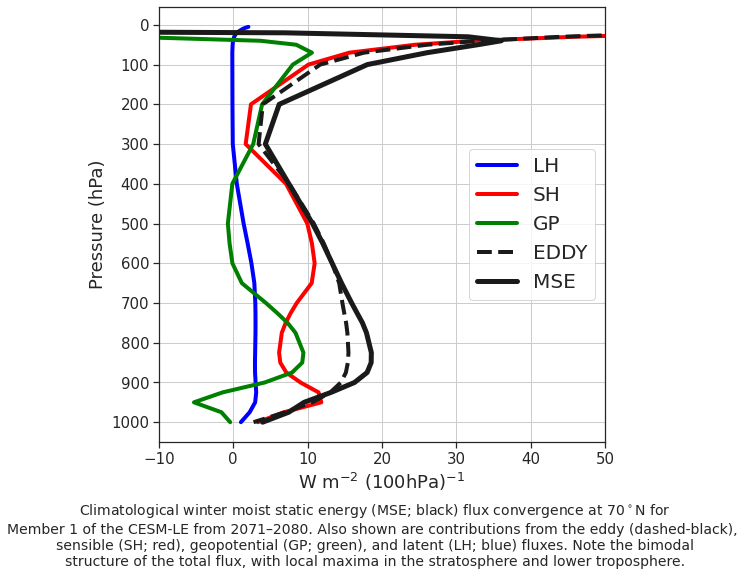

In [38]:
fig = plt.figure( figsize=(8,8) )
ax = plt.subplot(111)
(LH_flux_m1.sel(time=winter_D).mean('time')*comp.h()).plot(yincrease=False,y='plev',c='blue',lw=4,label='LH')
(SH_flux_m1.sel(time=winter_D).mean('time')*comp.h()).plot(yincrease=False,y='plev',c='red',lw=4,label='SH')
(GP_flux_m1.sel(time=winter_D).mean('time')*comp.h()).plot(yincrease=False,y='plev',c='green',lw=4,label='GP')
(EDDY_flux_m1.sel(time=winter_D).mean(['time','lon'])*comp.h()).plot(yincrease=False,y='plev',c='k',ls='--',lw=4,label='EDDY')
((GP_flux_m1+SH_flux_m1+LH_flux_m1).sel(time=winter_D).mean('time')*comp.h()).plot(yincrease=False,y='plev',c='k',lw=5,label='MSE')
ax.set_xbound(-10,50)
ax.legend(loc='center right',prop={'size': 20})
ax.set_yticks(np.arange(0,110000,10000));ax.set_yticklabels(np.arange(0,1100,100))
ax.set_ylabel('Pressure (hPa)',fontsize=18);ax.set_xlabel('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=18)
ax.tick_params(labelsize=15)
txt = """Climatological winter moist static energy (MSE; black) flux convergence at 70$^\circ$N for
Member 1 of the CESM-LE from 2071–2080. Also shown are contributions from the eddy (dashed-black), 
sensible (SH; red), geopotential (GP; green), and latent (LH; blue) fluxes. Note the bimodal
structure of the total flux, with local maxima in the stratosphere and lower troposphere."""
fig.text(.5, -.09, txt, ha='center', fontsize=14)
ax.set_title('')
ax.grid()

In the long-term average, stratospheric fluxes (integrated above 300 hPa) have little influence on the net surface flux (NSF; [Cardinale et al., 2021](https://journals.ametsoc.org/view/journals/clim/34/11/JCLI-D-20-0722.1.xml)). The remainder of the section will focus on the tropospheric energy flux convergence ($F_{\mathrm{trop}}$).

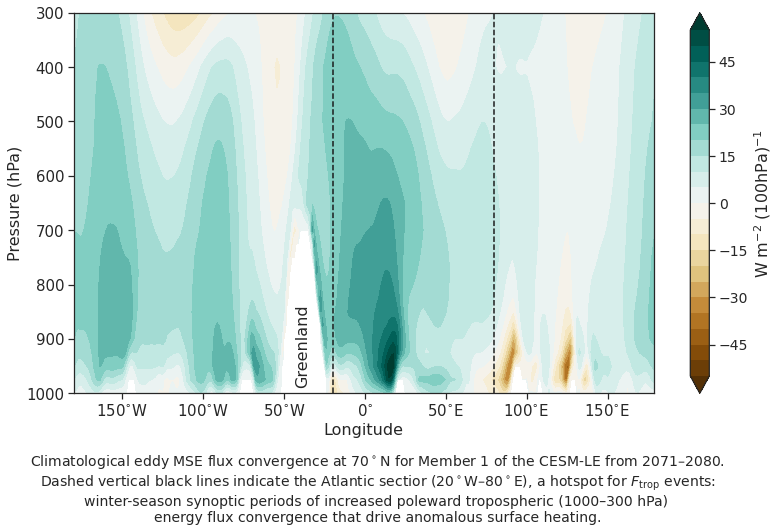

In [39]:
fig = plt.figure( figsize=(13,7) )
ax = plt.subplot(111)
lev=np.arange(-55,60,5)
mask_EDDY=(EDDY_flux_m1.sel(time=winter_D).mean('time').where(EDDY_flux_m1.mean('time')!=0))*0+1
EDDY_roll = (EDDY_flux_m1.sel(time=winter_D).mean('time')*comp.h()*mask_EDDY).roll(lon=144,roll_coords=True)
EDDY_roll['lon'] = np.arange(-180,180,1.25)
im=EDDY_roll.sel(plev=slice(30000,100000)).plot.contourf(
    y='plev', yincrease=False,ax=ax,cmap=plt.cm.BrBG,levels=lev,extend='both',add_colorbar=False)
cbar=plt.colorbar(im,ax=ax)
cbar.set_label('W m$^{-2}$ (100hPa)$^{-1}$',fontsize=16)
cbar.ax.tick_params(labelsize=14) 
ax.set_xticklabels(['','$150^{\circ}$W','$100^{\circ}$W','$50^{\circ}$W','$0^{\circ}$',
                   '$50^{\circ}$E','$100^{\circ}$E','$150^{\circ}$E'])
ax.set_yticklabels(np.arange(300,1100,100))
ax.set_ylabel('Pressure (hPa)',fontsize=16);ax.set_xlabel('Longitude',fontsize=16)
ax.tick_params(labelsize=15)
ax.axvline(-20,ls='--',color='k');ax.axvline(80,ls='--',color='k')
txt = """Climatological eddy MSE flux convergence at 70$^\circ$N for Member 1 of the CESM-LE from 2071–2080. 
Dashed vertical black lines indicate the Atlantic sectior (20$^\circ$W–80$^\circ$E), a hotspot for $F_\mathrm{trop}$ events:
winter-season synoptic periods of increased poleward tropospheric (1000–300 hPa) 
energy flux convergence that drive anomalous surface heating."""
ax.set_title('')
fig.text(.45, -.13, txt, ha='center', fontsize=14);
fig.text(.37, .22, 'Greenland', ha="center", va="center", rotation=90, size=16);

### Example $F_{\mathrm{trop}}$ event and its efficiency

#### The efficiency with which $F_{\mathrm{trop}}$ heats the Arctic surface

$F_{\mathrm{trop}}$ can be defined as: 

$$F_{\mathrm{trop}}=\frac{C}{2\pi A} \int_{0}^{2\pi}\int_{300}^{P_{s}}  \big(c_p vT + g vz + L_v vq \big)\frac{d\lambda dp}{g},$$ 

where $t$ is temperature, $q$ is specific humidity, $z$ is geopotential height, and $v$ is the meridional wind (other abbreviations are defined at the beginning of each section). 

An increase in $F_{\mathrm{trop}}$ warms and moistens the Arctic troposphere. The net tropospheric energy source (NTES) represents the maximum or excess energy available for surface heating after accounting for the heating and moistening of the troposphere. NTES is computed by subtracting the moist enthalpy (sensible and latent heat) tendency ($\frac{\partial {h_{\textrm{m}}}}{\partial t}$) from $F_{\mathrm{trop}}$: 
$$\mathrm{NTES} = {F_{\textrm{trop}} - \int_{300}^{P_{s}} \langle \frac{\partial {h_{\textrm{m}}}}{\partial t} \rangle \frac{dp}{g}},$$

where angle brackets indicate polar cap averages.

A fraction of an anomalous increase in $F_{\textrm{trop}}$ is fluxed upward across the tropopause and does not impact the surface. A metric for the surface impact of $F_{\textrm{trop}}$; i.e., the surface heating efficiency ($E_{\mathrm{trop}}$) was defined in [Cardinale and Rose (2022a)](https://journals.ametsoc.org/view/journals/clim/35/18/JCLI-D-21-0852.1.xml) and measures the fraction of the anomalous NTES that is balanced by an anomalous NSF:

$$E_{\textrm{trop}} = \frac{ \langle {\textrm{NSF}}^\prime \rangle}{\textrm{NTES}^\prime},$$

where ***primes indicate anomalies relative to the daily mean annual cycle***. Here, the denominator (NTES$^\prime$) represents the maximum energy available for ***anomalous surface heating***. The interpretation that an NSF anomaly represents the fraction of an NTES anomaly that heats the surface should be approximately valid when $F_{\textrm{trop}}$ is anomalously *large*.

#### Compute anomalies and $E_{\mathrm{trop}}$

In [40]:
Ftrop = comp.integrate_trop((LH_flux_m1+SH_flux_m1+GP_flux_m1)*C/A)
NTES = Ftrop - (comp.integrate_trop(dhmdt_m1/sid))
NSF = (NLR_m1+SHLH_m1)

Linearly detrend for a stationary timeseries.

In [41]:
Ftrop_anom = comp.detrend(comp.anom_daily_filt(Ftrop,winter_ext_D))
dhmdt_anom =  comp.detrend(comp.anom_daily_filt(comp.integrate_trop(dhmdt_m1/sid),winter_ext_D))
NTES_anom = comp.detrend(comp.anom_daily_filt(NTES,winter_ext_D))
EDDY_anom = comp.detrend(comp.anom_daily_filt(EDDY_flux_m1,winter_ext_D))
NSF_anom = comp.detrend(comp.anom_daily_filt(NSF).sel(time=winter_ext_D))
T2M_anom = comp.detrend(comp.anom_daily_filt(T2M_m1).sel(time=winter_ext_D))
SIC_anom = comp.detrend(comp.anom_daily_filt(SIC_m1).sel(time=winter_ext_D))

no nans found
nans found, array filled using ffill and bfill
nans found, array filled using ffill and bfill
no nans found
no nans found
no nans found
no nans found


<div class="alert alert-info">
    
<strong>Note:</strong> 
    
<p>Detrending arrays requires no <code>nan</code> values—when found, the arrays are filled with either the previous or following value.</p>
    
<p>Only the winter season is considered: absorbed shortwave radiation is negligable and the NSF is comprised of NLR and SHLH. NSF anomalies are positive <em>downward</em>.</p>
    
</div>

In [42]:
E_trop = (NSF_anom/ufunc2(NTES_anom,comp.low_filt))

#### $E_\mathrm{trop}$ during an $F_\mathrm{trop}$ event

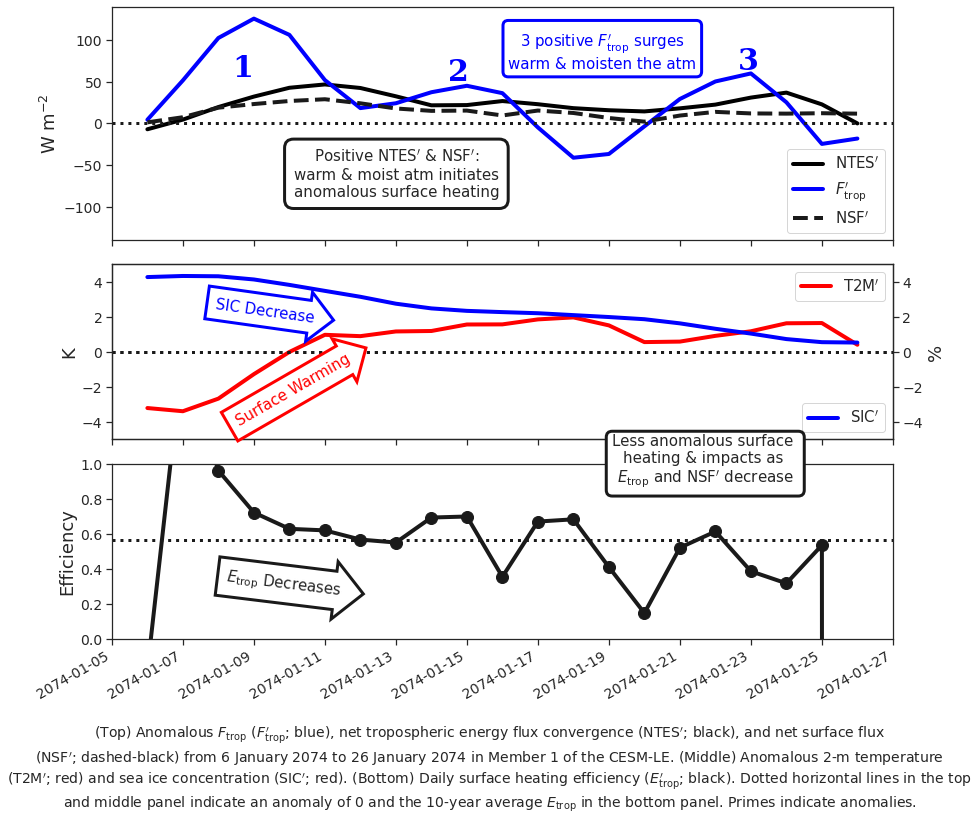

In [43]:
import matplotlib.dates as mdates
fig = plt.figure( figsize=(13,10) )
gs = plt.GridSpec(3, 1,
                       width_ratios=[1],
                       height_ratios=[1,.75,.75]
                       )
ax = fig.add_subplot(gs[0])
ufunc2(NTES_anom,comp.low_filt).sel(time=slice('2074-01-06','2074-01-26')).plot(ax=ax,c='black',lw=4,label="NTES$^\prime$")
ufunc2(Ftrop_anom,comp.low_filt).sel(time=slice('2074-01-06','2074-01-26')).plot(ax=ax,c='blue',lw=4,label="$F_\mathrm{trop}^\prime$")
NSF_anom.sel(time=slice('2074-01-06','2074-01-26')).plot(ax=ax,c='k',ls='--',lw=4,label="NSF$^\prime$")
ax2 = fig.add_subplot(gs[1])
T2M_anom.sel(time=slice('2074-01-06','2074-01-26')).plot(ax=ax2,c='red',lw=4,label="T2M$^\prime$")
ax3=ax2.twinx()
(SIC_anom*100).sel(time=slice('2074-01-06','2074-01-26')).plot(ax=ax3,c='blue',lw=4,label="SIC$^\prime$")
ax4 = fig.add_subplot(gs[2])
E_trop.sel(time=slice('2074-01-06','2074-01-26')).plot(color='k',ax=ax4,lw=4,marker='o',ms=12)
ax.set_ybound(-140,140);ax2.set_ybound(-5,5);ax3.set_ybound(-5,5);ax4.set_ybound(0,1)
ax.axhline(y=0, color='k', linestyle=':',lw=3);ax2.axhline(y=0, color='k', linestyle=':',lw=3);ax3.axhline(y=0, color='k', linestyle=':',lw=3)
ax4.axhline(y=E_trop.where(np.logical_and(E_trop>0,E_trop<1)).mean('time'), color='k', linestyle=':',lw=3)
ax.set_xlabel('');ax2.set_xlabel('');ax3.set_xlabel('');ax4.set_xlabel('')
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax3.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax4.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax.set_xticklabels('');ax2.set_xticklabels('');ax3.set_xticklabels('')
ax.set_ylabel('W m$^{-2}$',fontsize=18);ax2.set_ylabel('K',fontsize=18);ax3.set_ylabel('%',fontsize=18);ax4.set_ylabel('Efficiency',fontsize=18)
fig.text(.225,.885,'1',c='blue',fontsize=30,family='serif',weight='bold')
fig.text(.455,.88,'2',c='blue',fontsize=30,family='serif',weight='bold')
fig.text(.765,.895,'3',c='blue',fontsize=30,family='serif',weight='bold')
fig.text(.29, .45, "Surface Warming", ha="center", va="center", rotation=30, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="w", ec="red", lw=3),c='red')

fig.text(.26, .56, "SIC Decrease", ha="center", va="center", rotation=-8, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="w", ec="blue", lw=3),c='blue')
fig.text(.62, .92, """3 positive $F_{\mathrm{trop}}^\prime$ surges
warm & moisten the atm""", ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="round,pad=0.35", fc="w", ec="blue", lw=3),c='blue')
fig.text(.40, .75, """Positive NTES$^\prime$ & NSF$^\prime$:
warm & moist atm initiates
anomalous surface heating""", ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="round,pad=0.6", fc="w", ec="k", lw=3))
fig.text(.28, .18, "$E_{\mathrm{trop}}$ Decreases", ha="center", va="center", rotation=-7, size=15,
    bbox=dict(boxstyle="rarrow,pad=0.6", fc="w", ec="k", lw=3))
fig.text(.73, .35, """Less anomalous surface 
heating & impacts as 
$E_{\mathrm{trop}}$ and NSF$^\prime$ decrease""", ha="center", va="center", rotation=0, size=15,
    bbox=dict(boxstyle="round,pad=0.4", fc="w", ec="k", lw=3))
ax.set_title('');ax2.set_title('');ax3.set_title('');ax4.set_title('')
ax.tick_params(labelsize=14);ax2.tick_params(labelsize=14);ax3.tick_params(labelsize=14);ax4.tick_params(labelsize=14)
ax.legend(loc='lower right',fontsize=15)
ax2.legend(loc='upper right',fontsize=15)
ax3.legend(loc='lower right',fontsize=15)
txt = """(Top) Anomalous $F_{\mathrm{trop}}$ ($F_{\mathrm{trop}}^\prime$; blue), net tropospheric energy flux convergence (NTES$^\prime$; black), and net surface flux 
(NSF$^\prime$; dashed-black) from 6 January 2074 to 26 January 2074 in Member 1 of the CESM-LE. (Middle) Anomalous 2-m temperature 
(T2M$^\prime$; red) and sea ice concentration (SIC$^\prime$; red). (Bottom) Daily surface heating efficiency ($E_{\mathrm{trop}}^\prime$; black). Dotted horizontal lines in the top 
and middle panel indicate an anomaly of 0 and the 10-year average $E_{\mathrm{trop}}$ in the bottom panel. Primes indicate anomalies."""
ax.set_title('')
fig.text(.5, -.13, txt, ha='center', fontsize=14);
fig.tight_layout()

Structure of above "event":

- 3 poleward surges of $F_\mathrm{trop}^\prime$ warm and moisten the Arctic troposphere, leading to an approximately 3-week period of positive NTES$^\prime$.
- A fraction of NTES$^\prime$ goes into surface heating, indicated by the positive NSF$^\prime$.
- The surface heating is associated with both surface warming and sea ice loss.
- $E_{\mathrm{trop}}$ generally decreases with time, which indicates reduced surface impacts (e.g., less surface warming).

<div class="alert alert-info">
    
<strong>Note:</strong> 

<p>Surface impacts also decrease during the event when the NTES anomaly decreases.</p>
    
<p>A formal definition of an $F_\mathrm{trop}$ event is given in a separate notebook.</p>
    
<p>2-m temperature anomalies are used as a proxy for surface temperature anomalies.</p>
    
</div>

In [44]:
print('Percentage of days when the efficiency is between 0 and 1: {:2.2%}'.format(
    (E_trop.sel(time=winter_D).where(np.logical_and(E_trop>0,E_trop<1)).count()
                        /E_trop.sel(time=winter_D).size).values))

Percentage of days when the efficiency is between 0 and 1: 59.58%


As observed in the above figure, $E_\mathrm{trop}$ does not always fall between 0 and 1. These are typically days when anomalous $F_\mathrm{trop}$ and NTES are small—these are days when the atmosphere has little potential to drive surface heating or is not the dominant driver of NSF anomalies. Over the 10-year period of the member 1, $E_\mathrm{trop}$ falls outside the 0 and 1 range on 40% of days.

### Winter mean $E_\mathrm{trop}$

On short timescales, $E_\mathrm{trop}$ can help provide insight into the processes that drive Arctic surface warming and sea ice loss. Averaged over a climatological period, $E_\mathrm{trop}$ measures the coupling between $F_\mathrm{trop}$ and the Arctic surface energy budget. 

In [45]:
print('Winter average efficiency: {:2.2%}'.format(
    E_trop.sel(time=winter_D).where(np.logical_and(E_trop>0,E_trop<1)).mean().values))

print('Winter average NTES: {:2.4} W/m2'.format(NTES.sel(time=winter_D).mean().values))

Winter average efficiency: 56.94%
Winter average NTES: 89.19 W/m2


The winter (NDJFM) average $E_\mathrm{trop}$ is 57%. This value approximates the fraction of the raw NTES (89 W m$^{-2}$) that reaches the surface

The change in the winter mean $E_\mathrm{trop}$ between two periods estimates changes in the coupling between $F_\mathrm{trop}$ and the surface energy budget. Changes in $E_\mathrm{trop}$ should be considered (along with changes in $F_\mathrm{trop}$) when quantifying the contribution from atmospheric energy transport to Arctic surface warming.

<div class="alert alert-info">
    
<strong>Note:</strong> A second notebook will provide code for the figures and selected results from <a href="https://www.essoar.org/doi/10.1002/essoar.10512237.1">Cardinale and Rose (2022b)</a>.
    
</div>

### Close cluster and disconnect client

In [46]:
cluster.close()
client.close()